# Experiment 7: Time Series
### Name: Nachiket Sankhe
### UID: 2019120053
### Class: BE EXTC

### Dataset Decription

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

In this notebook we will be exploring and creating our model based on the PJM East Region

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Importing the necessary libraries

In [ ]:
pjme = pd.read_csv('./energy_consumption/PJME_hourly.csv', index_col=[0], parse_dates=[0])

Reading the data from the required csv file

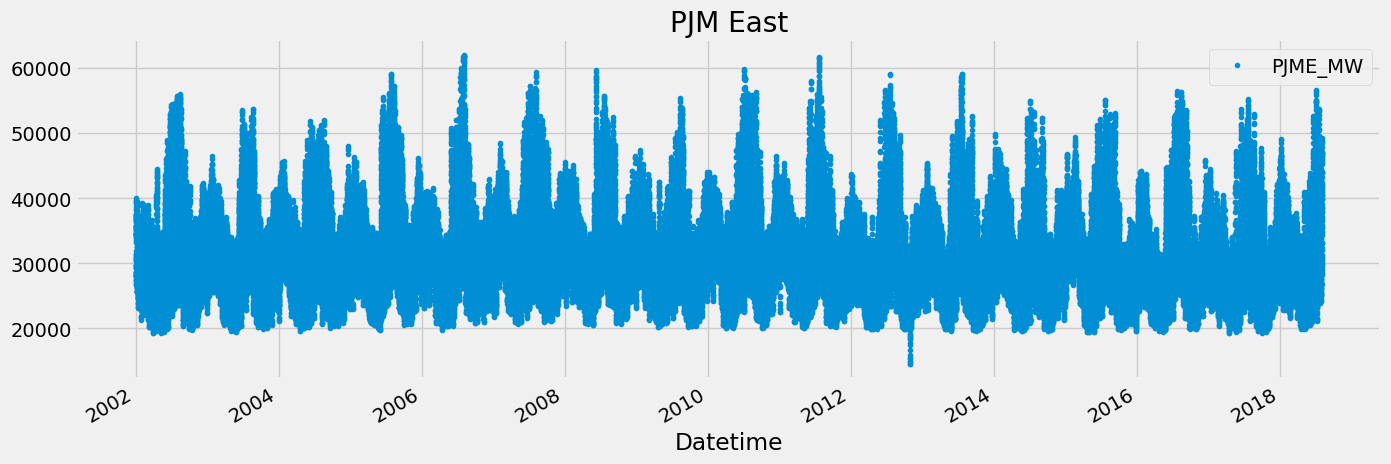

In [ ]:
_ = pjme.plot(style='.', figsize=(15,5), title='PJM East')

Plotting the data points as per the date given in the dataset

In [ ]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

Here we have chosen January 1st 2015 as the date to split our data into training and testing sets

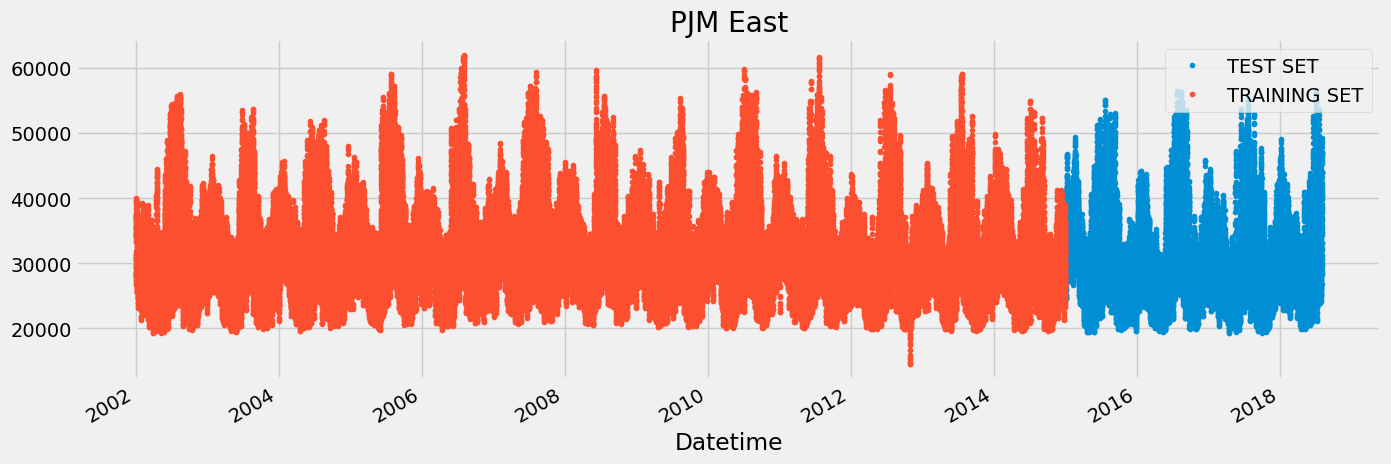

In [ ]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

Visualising the training and testing set with different colours

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

This function converts the columns into their appropriate data types and creates the input and target dataframes.

In [ ]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

C:\Users\jayes\AppData\Local\Temp\ipykernel_18332\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\jayes\AppData\Local\Temp\ipykernel_18332\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


Applying the created function on our created training and testing sets to prepare them for modelling

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\jayes\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Creating an XGBoost Regressor and training it on our previously created training and testing sets

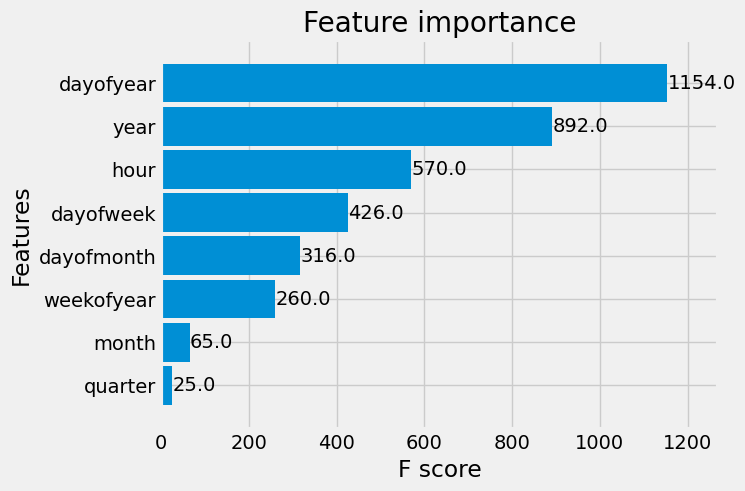

In [ ]:
_ = plot_importance(reg, height=0.9)

Plotting the importance of features based on their F Score using the plot_importance method from the XGBoost library

In [ ]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

Predicting on our test set using the created model.

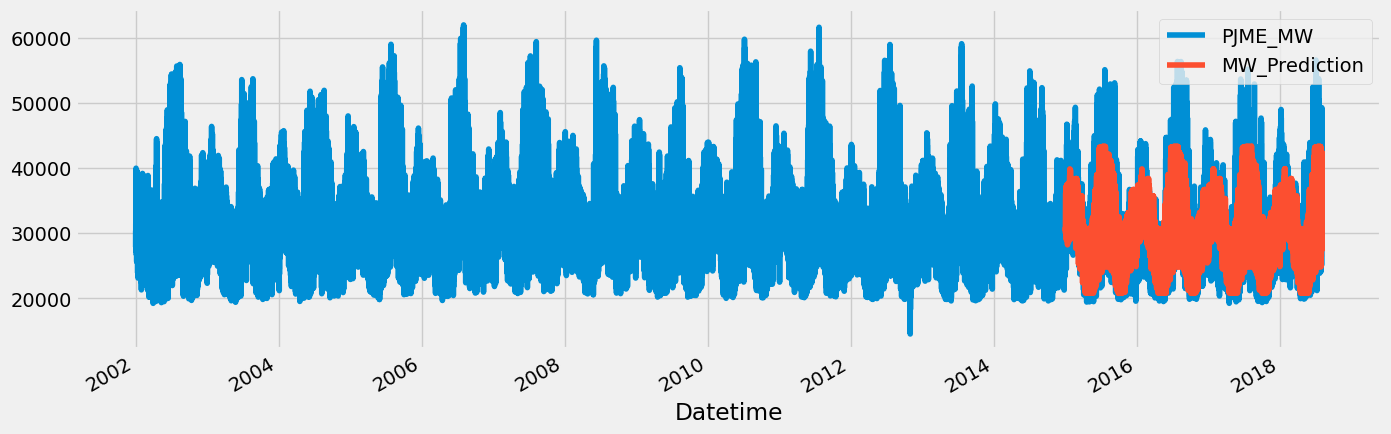

In [ ]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

Joining our predictions with the existing dataset and plotting it to compare our predictions

In [ ]:
print('Mean Squared Error:')
mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction'])

Mean Squared Error:


13960913.30565261

In [ ]:
print('Mean Absolute Error:')
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction'])

Mean Absolute Error:


2757.2169004982866

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('Mean Absolute Percentage Error:')
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction'])

Mean Absolute Percentage Error:


8.510847348494002

### Conclusion:
- Successfully implemented a time series prediction model using the xgboost library in Python.
- We can clearly observe that day of the year is the most important feature in the dataset followed by year and hour.
- Calculated the various errors associated with the model and obtained an absolute error percentage of 8.51%.